In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.model.mpra_basset import MPRA_Basset
from boda.generator.energy import OverMaxEnergy, StremePenalty
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()
print('')

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode



In [3]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis       
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 

        
def df_to_onehot_tensor(in_df, seq_column='sequence'):
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

def fasta_to_tensor(file_name):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    return torch.stack(seq_tensors, dim=0)

In [4]:
# class IntegratedSampledGradients(nn.Module):
#     def __init__(self,
#                  target_distributions,
#                  predictor,
#                  baseline=None,
#                  num_samples=1,
#                  batch_dim=0,
#                  token_dim=-2,
#                  cat_dim=-1,
#                  theta_factor=20):
#         super().__init__()
#         self.predictor = predictor  
#         self.baseline = baseline
#         self.num_samples = num_samples
#         self.batch_dim = batch_dim
#         self.token_dim = token_dim
#         self.cat_dim = cat_dim
#         self.theta_factor = theta_factor
        
#         self.register_buffer('target_thetas', self.theta_factor * target_distributions)
#         self.target_thetas.requires_grad_()       
#         self.grad = torch.autograd.grad
        
#         self.num_classes = self.target_thetas.shape[self.token_dim]
#         self.batch_size = self.target_thetas.shape[self.batch_dim]
#         self.n_dims = len(self.target_thetas.shape)
#         self.repeater = [ 1 for i in range(self.n_dims) ]

#         if self.baseline == None:
#             base_theta = torch.zeros_like(self.target_thetas)
#             self.register_buffer('base_theta', base_theta)
#         else:
#             self.register_buffer('base_theta', baseline.view(self.target_thetas.shape))
#         self.base_theta.requires_grad_()
        
#     def rebatch(self, input):
#         return input.unflatten(0, (self.num_samples, self.batch_size)).mean(dim=0)

#     def get_samples(self, theta):
#         distribution = F.softmax(theta, dim=self.token_dim)
#         nucleotide_probs = Categorical(torch.transpose(distribution, self.token_dim, self.cat_dim))
#         sampled_idxs = nucleotide_probs.sample((self.num_samples, ))
#         sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=self.num_classes)        
#         sampled_nucleotides = torch.transpose(sampled_nucleotides_T, self.token_dim, self.cat_dim)
#         multi_distribution = distribution.repeat(self.num_samples, *self.repeater)
#         sampled_nucleotides = sampled_nucleotides - multi_distribution.detach() + multi_distribution 
#         return sampled_nucleotides

#     def get_gradients(self, thetas):
#         samples = self.get_samples(thetas).flatten(0,1)
#         predictions = self.rebatch(self.predictor(samples))
#         gradients = self.grad(predictions.sum(), inputs=thetas, retain_graph=True)[0]
#         return gradients

#     def integrate_gradients(self, num_steps=50, num_samples=20):
#         self.num_samples = num_samples
#         line_gradients = [self.get_gradients(i / num_steps * self.target_thetas) for i in range(0, num_steps + 1)]
#         return torch.stack(line_gradients).mean(dim=0)
    
#     def get_salient_maps(self, num_steps=50, num_samples=20):
#         gradients = self.integrate_gradients(num_steps, num_samples=num_samples).to(self.target_thetas.device)        
#         salient_maps =  gradients * self.target_thetas
#         return salient_maps.detach()
    
    
class IntegratedSampledGradients(nn.Module):
    def __init__(self,
                 target_distributions,
                 predictor,
                 baseline=None,
                 num_samples=1,
                 batch_dim=0,
                 token_dim=-2,
                 cat_dim=-1,
                 theta_factor=20):
        super().__init__()
        self.predictor = predictor  
        self.baseline = baseline
        self.num_samples = num_samples
        self.batch_dim = batch_dim
        self.token_dim = token_dim
        self.cat_dim = cat_dim
        self.theta_factor = theta_factor
        
        self.register_buffer('target_thetas', self.theta_factor * target_distributions)
        self.target_thetas.requires_grad_()       
        self.grad = torch.autograd.grad
        
        self.num_classes = self.target_thetas.shape[self.token_dim]
        self.batch_size = self.target_thetas.shape[self.batch_dim]
        self.n_dims = len(self.target_thetas.shape)
        self.repeater = [ 1 for i in range(self.n_dims) ]

        if self.baseline == None:
            base_theta = torch.zeros_like(self.target_thetas)
            self.register_buffer('base_theta', base_theta)
        else:
            self.register_buffer('base_theta', baseline.view(self.target_thetas.shape))
        self.base_theta.requires_grad_()
        
    def rebatch(self, in_tensor):
        return in_tensor.unflatten(0, (self.num_samples, self.batch_size)).mean(dim=0)

    def get_samples(self, theta):
        distribution = F.softmax(theta, dim=self.token_dim)
        nucleotide_probs = Categorical(torch.transpose(distribution, self.token_dim, self.cat_dim))
        sampled_idxs = nucleotide_probs.sample((self.num_samples, ))
        sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=self.num_classes)        
        sampled_nucleotides = torch.transpose(sampled_nucleotides_T, self.token_dim, self.cat_dim)
        multi_distribution = distribution.repeat(self.num_samples, *self.repeater)
        sampled_nucleotides = sampled_nucleotides - multi_distribution.detach() + multi_distribution 
        return sampled_nucleotides

    def get_gradients(self, thetas):
        samples = self.get_samples(thetas).flatten(0,1)
        predictions = self.rebatch(self.predictor(samples))
        gradients = self.grad(predictions.sum(), inputs=thetas, retain_graph=True)[0]
        return gradients

    def integrate_gradients(self, num_steps=50, num_samples=20):
        self.num_samples = num_samples
        line_gradients = [self.get_gradients(i / num_steps * self.target_thetas) for i in range(0, num_steps + 1)]
        return torch.stack(line_gradients).mean(dim=0)
    
    def get_salient_maps(self, num_steps=50, num_samples=20):
        gradients = self.integrate_gradients(num_steps, num_samples=num_samples).to(self.target_thetas.device)        
        salient_maps =  gradients * self.target_thetas
        return salient_maps.detach()

In [5]:
john_promoter = '''ACGACAGGTTTCCAAAGCTGTCAAAAAATCTCTGGGTCCAGGGGTAAACA
ACGAGGAGTCTATGAAATGACACCATATCAGATACAAAATTAGAGATGCA
AAAAATCTTGAGGACTTTCCCAATCAACTTGCTAGGGTAATATTCACCCT
TCATTCCCATGCATTGAGAACCAATGCTTACCTGCCCAAGGCTTCACCTC
CAGCCTCTTCCACATTCATCTTGCTCCACAGGCTAGTGACGGCAGCCTTC
TCCTCAGCAGTAAAATGCACCATGATGCCAGGCCTGAGAGCTTGCTAGTG
ATTGCAGCTGTGTCGGAAGCAGATATGTGCTGCTGCCTCTCTGTCTGGCC
TTTTATTCTTTACTGCCGAAGTTCTGGCCCCCTGTTCTCCATGGTACTTA
AAAGTCATTGGTCAAGGCTGACCTGTGTCCCTCAGGGGTGGAGTCAGGTC
CGGAGAGGGTCAGCAGTGATGGATGGACACTAAGTTTGTGATAATGTGTG
CTGGATCCTGAGGCTCTTTTTTGTTGGCTCCTCATCTATCTGCAACACAA
ATTTCCATTTGTCCCCTTTTTTACCCTCTTCATCATCTTCCAAAATGATA
TCCATCTCTCCCATTCTCCTTTTCCAAGAAAGCCTCATATAAAGGAGCAA
ATCTCAAAATAGGAAAAAAAGTTTCAGCCAAAGCGCATTTAACATTTGCC
TTAAAGGTGGTGACAGTGACAAAAACAGGGCCAAGGAAAAGAAAATAAAG
CTGTTAAAACAGAATCTCACCCAGTTCTAGCTCTCTTAAGGAGTGCATTG
TAAACAAAACT'''

test_sequence = ''.join(john_promoter.split('\n'))
window_size = 200
test_distributions = torch.stack([utils.dna2tensor(test_sequence[i:i+window_size]) for i in range(len(test_sequence)-window_size)])

In [6]:
k562_predictor = mpra_predictor(model=model, pred_idx=0).cuda()

## Try new implementation (avoid for-loop to get line)

In [64]:
def integrated_sampled_gradients(sequences,
                                 predictor,
                                 num_steps=50,
                                 num_samples=20,
                                 eval_batch_size=1024,
                                 theta_factor=15):
    
    batch_size = eval_batch_size // (num_steps * num_samples)
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    all_salient_maps = []
    for local_batch in tqdm(temp_dataloader):
        batch_thetas = (theta_factor * local_batch[0].cuda())
        point_thetas = torch.stack([(i / num_steps) * batch_thetas for i in range(0, num_steps + 1)]).requires_grad_()

        point_distributions = F.softmax(point_thetas, dim=-2)
        nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
        sampled_idxs = nucleotide_probs.sample((num_samples, ))
        sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
        sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
        distribution_repeater = point_distributions.repeat(num_samples, *[ 1 for i in range(4) ])
        sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater 
        samples = sampled_nucleotides.flatten(0,2)
        
        preds = k562_predictor(samples)
        predictions = preds.unflatten(0, (num_samples, num_steps+1, batch_thetas.shape[0])).mean(dim=0)
        gradients = torch.autograd.grad(predictions.sum(), inputs=point_thetas, retain_graph=True)[0].mean(dim=0)
        all_salient_maps.append((gradients * batch_thetas).cpu())
        
    return all_salient_maps

In [65]:
%%time
all_salient_maps = integrated_sampled_gradients(sequences=test_distributions, predictor=k562_predictor)

  0%|          | 0/611 [00:00<?, ?it/s]

CPU times: user 1min 2s, sys: 564 ms, total: 1min 3s
Wall time: 1min 3s


In [66]:
salient_maps = torch.cat(all_salient_maps)#.detach()

total_length = salient_maps.shape[0] + salient_maps.shape[-1]
full_window_contributions = []
for i in range(salient_maps.shape[0]):
    local_contributions = torch.zeros(4, total_length)
    local_contributions[:,i:i+salient_maps.shape[-1]] = salient_maps[i,:,:]
    full_window_contributions.append(local_contributions)
full_window_contributions = torch.stack(full_window_contributions)

promoter_contributions = full_window_contributions.sum(dim=0)[:,199:-199] / 200

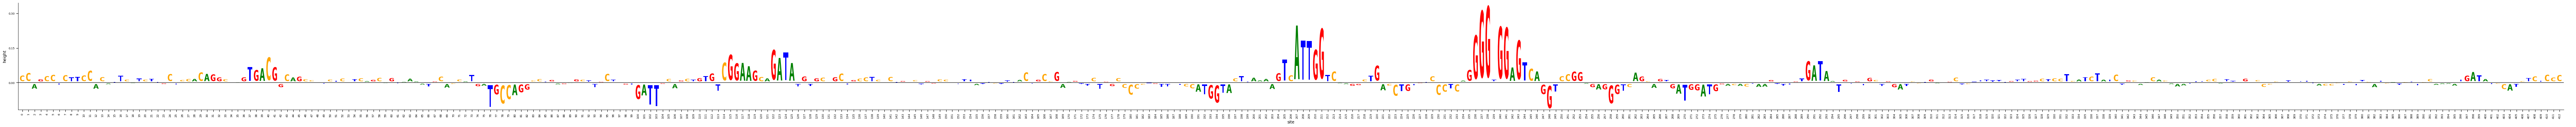

In [67]:
matrix = promoter_contributions.view(4,-1)
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=2)
plt.show()

## Compare to original implementation

In [16]:
%%time

temp_dataset = TensorDataset(test_distributions)
temp_dataloader = DataLoader(temp_dataset, batch_size=60, shuffle=False, num_workers=2)

all_salient_maps = []
for local_batch in tqdm(temp_dataloader):
    attributer = IntegratedSampledGradients(local_batch[0], k562_predictor, theta_factor=15).cuda()
    all_salient_maps.append(attributer.get_salient_maps(num_steps=50, num_samples=20).cpu())

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 1min 1s, sys: 247 ms, total: 1min 1s
Wall time: 1min 1s


In [17]:
salient_maps = torch.cat(all_salient_maps)

total_length = salient_maps.shape[0] + salient_maps.shape[-1]
full_window_contributions = []
for i in range(salient_maps.shape[0]):
    local_contributions = torch.zeros(4, total_length)
    local_contributions[:,i:i+salient_maps.shape[-1]] = salient_maps[i,:,:]
    full_window_contributions.append(local_contributions)
full_window_contributions = torch.stack(full_window_contributions)

promoter_contributions = full_window_contributions.sum(dim=0)[:,199:-199] / 200

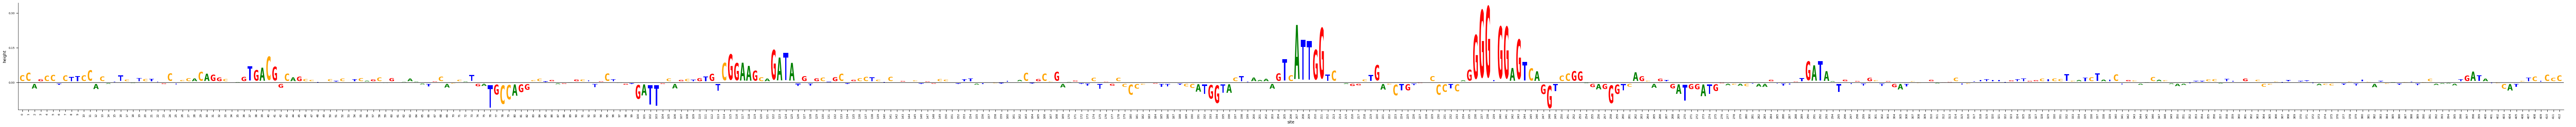

In [18]:
matrix = promoter_contributions.view(4,-1)
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=2)
plt.show()

## Original implementation as a single function

In [ ]:
class IntegratedSampledGradients(nn.Module):
    def __init__(self,
                 target_distributions,
                 predictor,
                 baseline=None,
                 num_samples=1,
                 batch_dim=0,
                 token_dim=-2,
                 cat_dim=-1,
                 theta_factor=20):
        super().__init__()
        self.predictor = predictor  
        self.baseline = baseline
        self.num_samples = num_samples
        self.batch_dim = batch_dim
        self.token_dim = token_dim
        self.cat_dim = cat_dim
        self.theta_factor = theta_factor
        
        self.register_buffer('target_thetas', self.theta_factor * target_distributions)
        self.target_thetas.requires_grad_()       
        self.grad = torch.autograd.grad
        
        self.num_classes = self.target_thetas.shape[self.token_dim]
        self.batch_size = self.target_thetas.shape[self.batch_dim]
        self.n_dims = len(self.target_thetas.shape)
        self.repeater = [ 1 for i in range(self.n_dims) ]

        if self.baseline == None:
            base_theta = torch.zeros_like(self.target_thetas)
            self.register_buffer('base_theta', base_theta)
        else:
            self.register_buffer('base_theta', baseline.view(self.target_thetas.shape))
        self.base_theta.requires_grad_()
        
    def rebatch(self, in_tensor):
        return in_tensor.unflatten(0, (self.num_samples, self.batch_size)).mean(dim=0)

    def get_samples(self, theta):
        distribution = F.softmax(theta, dim=self.token_dim)
        nucleotide_probs = Categorical(torch.transpose(distribution, self.token_dim, self.cat_dim))
        sampled_idxs = nucleotide_probs.sample((self.num_samples, ))
        sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=self.num_classes)        
        sampled_nucleotides = torch.transpose(sampled_nucleotides_T, self.token_dim, self.cat_dim)
        multi_distribution = distribution.repeat(self.num_samples, *self.repeater)
        sampled_nucleotides = sampled_nucleotides - multi_distribution.detach() + multi_distribution 
        return sampled_nucleotides

    def get_gradients(self, thetas):
        samples = self.get_samples(thetas).flatten(0,1)
        predictions = self.rebatch(self.predictor(samples))
        gradients = self.grad(predictions.sum(), inputs=thetas, retain_graph=True)[0]
        return gradients

    def integrate_gradients(self, num_steps=50, num_samples=20):
        self.num_samples = num_samples
        line_gradients = [self.get_gradients(i / num_steps * self.target_thetas) for i in range(0, num_steps + 1)]
        return torch.stack(line_gradients).mean(dim=0)
    
    def get_salient_maps(self, num_steps=50, num_samples=20):
        gradients = self.integrate_gradients(num_steps, num_samples=num_samples).to(self.target_thetas.device)        
        salient_maps =  gradients * self.target_thetas
        return salient_maps.detach()

In [52]:
def isg_contributions(sequences,
                      predictor,
                      num_steps=50,
                      num_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15):
    
    batch_size = eval_batch_size // num_samples
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    all_salient_maps = []
    for local_batch in tqdm(temp_dataloader):
        target_thetas = (theta_factor * local_batch[0].cuda()).requires_grad_()
        line_gradients = []
        for i in range(0, num_steps + 1):
            point_thetas = (i / num_steps * target_thetas)
            point_distributions = F.softmax(point_thetas, dim=-2)

            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1 for i in range(3)])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater 
            samples = sampled_nucleotides.flatten(0,1)

            preds = k562_predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)
            
        gradients = torch.stack(line_gradients).mean(dim=0) 
        all_salient_maps.append(gradients * target_thetas)
    return torch.cat(all_salient_maps)

In [53]:
%%time
salient_maps = isg_contributions(test_distributions, k562_predictor, eval_batch_size=1024)

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 1min, sys: 264 ms, total: 1min 1s
Wall time: 1min


In [54]:
total_length = salient_maps.shape[0] + salient_maps.shape[-1]
full_window_contributions = []
for i in range(salient_maps.shape[0]):
    local_contributions = torch.zeros(4, total_length)
    local_contributions[:,i:i+salient_maps.shape[-1]] = salient_maps[i,:,:]
    full_window_contributions.append(local_contributions)
full_window_contributions = torch.stack(full_window_contributions)

promoter_contributions = full_window_contributions.sum(dim=0)[:,199:-199] / 200

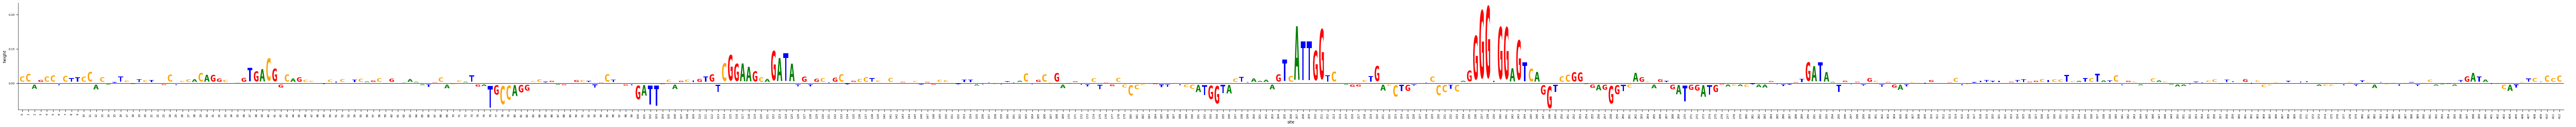

In [55]:
matrix = promoter_contributions.detach().view(4,-1)
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=2)
plt.show()

In [48]:
class IntegratedSampledGradients(nn.Module):
    def __init__(self,
                 target_distributions,
                 predictor,
                 baseline=None,
                 num_samples=1,
                 batch_dim=0,
                 token_dim=-2,
                 cat_dim=-1,
                 theta_factor=20):
        super().__init__()
        self.predictor = predictor  
        self.baseline = baseline
        self.num_samples = num_samples
        self.batch_dim = batch_dim
        self.token_dim = token_dim
        self.cat_dim = cat_dim
        self.theta_factor = theta_factor
        
        self.register_buffer('target_thetas', self.theta_factor * target_distributions)
        #self.target_thetas.requires_grad_()       
        self.grad = torch.autograd.grad
        
        self.num_classes = self.target_thetas.shape[self.token_dim]
        self.batch_size = self.target_thetas.shape[self.batch_dim]
        self.n_dims = len(self.target_thetas.shape)
        self.repeater = [ 1 for i in range(self.n_dims) ]

        if self.baseline == None:
            base_theta = torch.zeros_like(self.target_thetas)
            self.register_buffer('base_theta', base_theta)
        else:
            self.register_buffer('base_theta', baseline.view(self.target_thetas.shape))
        self.base_theta.requires_grad_()
        
    def rebatch(self, input):
        return input.unflatten(0, (self.num_samples, self.batch_size)).mean(dim=0)

    def get_samples(self, theta):
        distribution = F.softmax(theta, dim=self.token_dim)
        nucleotide_probs = Categorical(torch.transpose(distribution, self.token_dim, self.cat_dim))
        sampled_idxs = nucleotide_probs.sample((self.num_samples, ))
        sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=self.num_classes)        
        sampled_nucleotides = torch.transpose(sampled_nucleotides_T, self.token_dim, self.cat_dim)
        multi_distribution = distribution.repeat(self.num_samples, *self.repeater)
        sampled_nucleotides = sampled_nucleotides - multi_distribution.detach() + multi_distribution 
        return sampled_nucleotides

    def get_gradients(self, thetas):
        thetas.requires_grad_()
        samples = self.get_samples(thetas).flatten(0,1)
        predictions = self.rebatch(self.predictor(samples))
        gradients = self.grad(predictions.sum(), inputs=thetas, retain_graph=True)[0]
        return gradients

    def get_point_theta(self, k):
        return self.base_theta + k * (self.target_thetas - self.base_theta)

    def integrate_gradients(self, num_steps=10, num_samples=20):
        self.num_samples = num_samples
        line_gradients = []
        for i in range(0, num_steps + 1):
            slope = i / num_steps
            point_thetas = self.get_point_theta(slope)
            point_gradients = self.get_gradients(point_thetas)
            line_gradients.append(point_gradients)
        return torch.stack(line_gradients).mean(dim=0)
    
    def get_salient_maps(self, num_steps=10, num_samples=20):
        gradients = self.integrate_gradients(num_steps, num_samples=num_samples).to(self.target_thetas.device)        
        salient_maps =  gradients * self.target_thetas
        return salient_maps

In [49]:
%%time

temp_dataset = TensorDataset(test_distributions)
temp_dataloader = DataLoader(temp_dataset, batch_size=60, shuffle=False, num_workers=2)

all_salient_maps = []
for local_batch in tqdm(temp_dataloader):
    attributer = IntegratedSampledGradients(local_batch[0], k562_predictor, theta_factor=15).cuda()
    all_salient_maps.append(attributer.get_salient_maps(num_steps=50, num_samples=20).cpu())

salient_maps = torch.cat(all_salient_maps)

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 1min 1s, sys: 220 ms, total: 1min 1s
Wall time: 1min 1s


In [50]:
total_length = salient_maps.shape[0] + salient_maps.shape[-1]
full_window_contributions = []
for i in range(salient_maps.shape[0]):
    local_contributions = torch.zeros(4, total_length)
    local_contributions[:,i:i+salient_maps.shape[-1]] = salient_maps[i,:,:]
    full_window_contributions.append(local_contributions)
full_window_contributions = torch.stack(full_window_contributions)

promoter_contributions = full_window_contributions.sum(dim=0)[:,199:-199] / 200

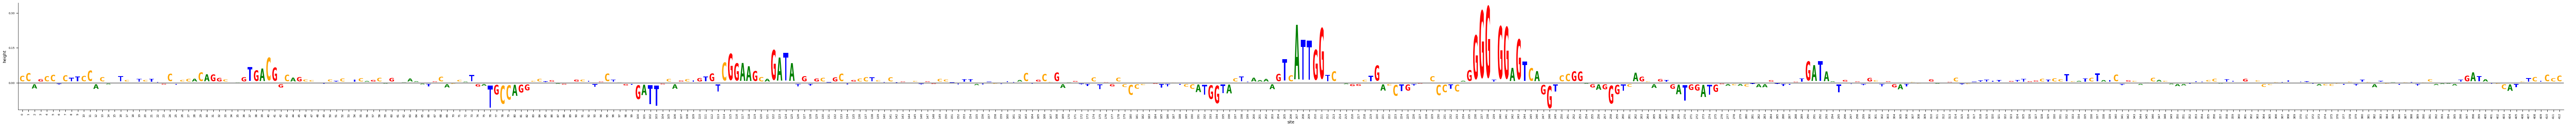

In [51]:
matrix = promoter_contributions.detach().view(4,-1)
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=2)
plt.show()

### Experiment with larger step size

In [70]:
step_size = 10
test_distributions = torch.stack([utils.dna2tensor(test_sequence[i:i+window_size]) for i in range(0, len(test_sequence)-window_size, step_size)])

In [72]:
%%time
salient_maps = isg_contributions(test_distributions, k562_predictor, eval_batch_size=1024)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 6.26 s, sys: 180 ms, total: 6.44 s
Wall time: 6.46 s


In [76]:
salient_maps.shape[0] + salient_maps.shape[-1]

262

In [ ]:
total_length = salient_maps.shape[0] + salient_maps.shape[-1]
full_window_contributions = []
for i in range(0, salient_maps.shape[0]):
    local_contributions = torch.zeros(4, total_length)
    local_contributions[:,i:i+salient_maps.shape[-1]] = salient_maps[i,:,:]
    full_window_contributions.append(local_contributions)
full_window_contributions = torch.stack(full_window_contributions)

promoter_contributions = full_window_contributions.sum(dim=0)[:,199:-199] / 200